In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner -q
import keras_tuner
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from timeit import default_timer as timer
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Unzipping the Datasets from Drive
!unzip /content/drive/MyDrive/Project/archive.zip

     |████████████████████████████████| 97 kB 3.6 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  app.launch_new_instance()


Archive:  /content/drive/MyDrive/Project/archive.zip
  inflating: data0.pickle            
  inflating: data1.pickle            
  inflating: data2.pickle            
  inflating: data3.pickle            
  inflating: data4.pickle            
  inflating: data5.pickle            
  inflating: data6.pickle            
  inflating: data7.pickle            
  inflating: data8.pickle            
  inflating: datasets_preparing.py   
  inflating: label_names.csv         
  inflating: labels.pickle           
  inflating: mean_image_gray.pickle  
  inflating: mean_image_rgb.pickle   
  inflating: std_gray.pickle         
  inflating: std_rgb.pickle          
  inflating: test.pickle             
  inflating: train.pickle            
  inflating: valid.pickle            


In [ ]:
# Opening the file & Reading the binary mode
with open('/content/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


(100, 32, 32, 3)


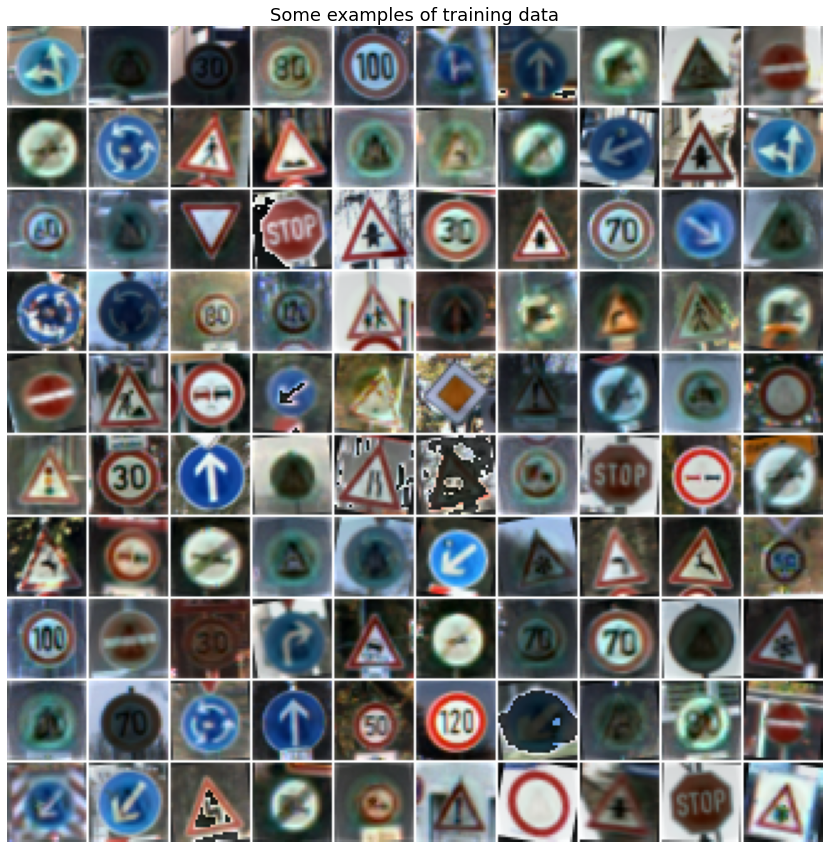

In [ ]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
              img = x_input[next_idx]
              low, high = np.min(img), np.max(img)
              grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
              next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][86889:86989, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras_tuner import HyperModel

In [ ]:
#filter_size = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
filter_size =  [3,5,7,9,11,13,15,19,23,25,29,31]
model = [0]*len(filter_size)

class MyHyperModel(HyperModel):
    def __init__(self, classes):
        self.classes = classes


    def build(self, hp):
      model[self.classes] = keras.Sequential([
        keras.layers.Conv2D(
            filters=32,
            kernel_size=filter_size[self.classes],
            activation='relu',
            padding = 'same',
            input_shape=(32,32,3)
        ),
        keras.layers.Conv2D(
            filters=64,
            kernel_size=filter_size[self.classes],
            activation='relu'
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=512, step=16),
            activation='relu'
        ),
        keras.layers.Dense(43, activation='softmax')
      ])

      model[self.classes].compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

      return model[self.classes]
  #tuner_search=RandomSearch(model[i],
  #                        objective='val_accuracy',
  #                        max_trials=5,directory='output',project_name="Traffic")
  #tuner_search.search(data['x_train'],data['y_train'],epochs=3, validation_data=(data['x_validation'], data['y_validation']))
  #model[i]=tuner_search.get_best_models(num_models=1)[0]
  #model[i].fit(data['x_train'],data['y_train'], epochs=8, validation_data=(data['x_validation'], data['y_validation']), initial_epoch=3)

In [ ]:
#filter_size = [3,5,9,11,19,23,]
#m = [0]*len(filters)
h = [0]*len(model)
for i in range(len(h)):
  hypermodel = MyHyperModel(classes=i)
  tuner_search=RandomSearch(hypermodel,
                          objective='val_accuracy',
                          overwrite='true',
                          max_trials=5,directory='output',project_name="Traffic")
  tuner_search.search(data['x_train'],data['y_train'],epochs=5, validation_data=(data['x_validation'], data['y_validation']))
  model[i]=tuner_search.get_best_models(num_models=1)[0]
  h[i] = model[i].fit(data['x_train'],data['y_train'], epochs=8, validation_data=(data['x_validation'], data['y_validation']), initial_epoch=3)

Trial 5 Complete [00h 03m 21s]
val_accuracy: 0.020408162847161293

Best val_accuracy So Far: 0.7770975232124329
Total elapsed time: 00h 17m 55s
INFO:tensorflow:Oracle triggered exit
Epoch 4/8
2719/2719 [==============================] - 41s 15ms/step - loss: 0.4483 - accuracy: 0.8742 - val_loss: 0.8656 - val_accuracy: 0.7880
Epoch 5/8
2719/2719 [==============================] - 40s 15ms/step - loss: 0.4054 - accuracy: 0.8857 - val_loss: 0.9555 - val_accuracy: 0.7884
Epoch 6/8
2719/2719 [==============================] - 40s 15ms/step - loss: 0.3912 - accuracy: 0.8901 - val_loss: 1.2631 - val_accuracy: 0.7295
Epoch 7/8
2719/2719 [==============================] - 40s 15ms/step - loss: 0.3641 - accuracy: 0.8974 - val_loss: 1.0089 - val_accuracy: 0.7893
Epoch 8/8
2719/2719 [==============================] - 40s 15ms/step - loss: 0.3437 - accuracy: 0.9034 - val_loss: 1.0057 - val_accuracy: 0.7980


In [ ]:
for i in range(len(h)):
  #model[i]=tuner_search.get_best_models(num_models=1)[0]
  #h[i] = model[i].fit(data['x_train'],data['y_train'], epochs=8, validation_data=(data['x_validation'], data['y_validation']), initial_epoch=3)
  print('Model with Filter '+str(filter_size[i])+'x'+str(filter_size[i]) +' training accuracy={:.5f}, validation accuracy={:.5f}'.\
    format(max(h[i].history['accuracy']), max(h[i].history['val_accuracy'])))

Model with Filter 3x3training accuracy=0.99616, validation accuracy=0.93855
Model with Filter 5x5training accuracy=0.99491, validation accuracy=0.96213
Model with Filter 7x7training accuracy=0.99213, validation accuracy=0.94036
Model with Filter 9x9training accuracy=0.99003, validation accuracy=0.93946
Model with Filter 11x11training accuracy=0.98523, validation accuracy=0.92222
Model with Filter 13x13training accuracy=0.97761, validation accuracy=0.90136
Model with Filter 15x15training accuracy=0.97063, validation accuracy=0.91383
Model with Filter 19x19training accuracy=0.95430, validation accuracy=0.89819
Model with Filter 23x23training accuracy=0.02344, validation accuracy=0.04762
Model with Filter 25x25training accuracy=0.02239, validation accuracy=0.05442
Model with Filter 29x29training accuracy=0.87659, validation accuracy=0.76871
Model with Filter 31x31training accuracy=0.90338, validation accuracy=0.79796


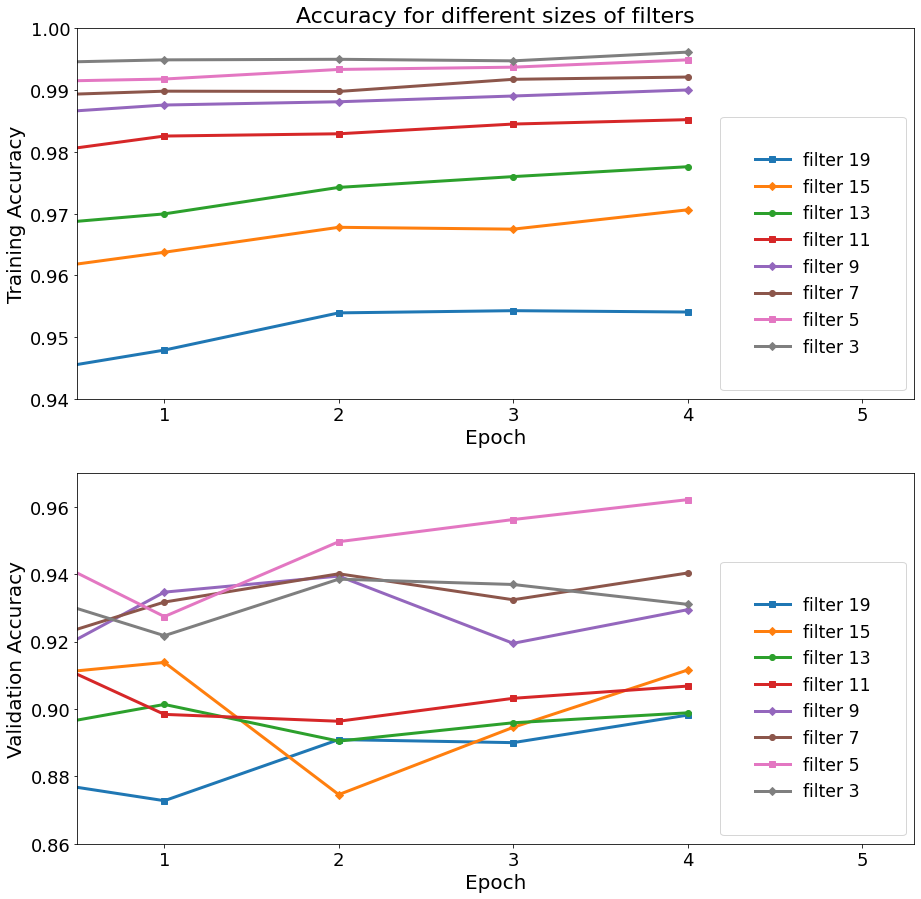

For the filter 3x3 training accuracy = 0.99616
For the filter 5x5 training accuracy = 0.99491
For the filter 7x7 training accuracy = 0.99213
For the filter 9x9 training accuracy = 0.99003
For the filter 11x11 training accuracy = 0.98523
For the filter 13x13 training accuracy = 0.97761
For the filter 15x15 training accuracy = 0.97063
For the filter 19x19 training accuracy = 0.95430

For the filter 3x3 validation accuracy = 0.93855
For the filter 5x5 validation accuracy = 0.96213
For the filter 7x7 validation accuracy = 0.94036
For the filter 9x9 validation accuracy = 0.93946
For the filter 11x11 validation accuracy = 0.92222
For the filter 13x13 validation accuracy = 0.90136
For the filter 15x15 validation accuracy = 0.91383
For the filter 19x19 validation accuracy = 0.89819


In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.family'] = 'Times New Roman'

# Plotting history of training accuracy
fig = plt.figure()
plt.subplot(2, 1, 1)
#plt.plot(h[14].history['accuracy'], '-o', linewidth=3.0)
#plt.plot(h[13].history['accuracy'], '-o', linewidth=3.0)
#plt.plot(h[12].history['accuracy'], '-o', linewidth=3.0)
#plt.plot(h[11].history['accuracy'], '>', linewidth=3.0)
#plt.plot(h[10].history['accuracy'], 'x', linewidth=3.0)
#plt.plot(h[9].history['accuracy'], '+', linewidth=3.0)
#plt.plot(h[8].history['accuracy'], '<', linewidth=3.0)
plt.plot(h[7].history['accuracy'], '-s', linewidth=3.0)
plt.plot(h[6].history['accuracy'], '-D', linewidth=3.0)
plt.plot(h[5].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[4].history['accuracy'], '-s', linewidth=3.0)
plt.plot(h[3].history['accuracy'], '-D', linewidth=3.0)
plt.plot(h[2].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[1].history['accuracy'], '-s', linewidth=3.0)
plt.plot(h[0].history['accuracy'], '-D', linewidth=3.0)
plt.legend(['filter 19', 'filter 15', 'filter 13','filter 11', 'filter 9','filter 7', 'filter 5', 'filter 3'], loc='lower right', fontsize='xx-large', borderpad=2)
#plt.legend(['filter 31', 'filter 25', 'filter 23'],loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Training Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.94, 1.0)
plt.xlim(0.5, 5.3) 
plt.title('Accuracy for different sizes of filters', fontsize=22)
plt.tick_params(labelsize=18)

plt.subplot(2, 1, 2)
#plt.gca().set_title('Validation accuracy')
#plt.plot(h[14].history['accuracy'], '-o', linewidth=3.0)
#plt.plot(h[13].history['accuracy'], '-o', linewidth=3.0)
#plt.plot(h[12].history['val_accuracy'], '-o', linewidth=3.0)
#plt.plot(h[11].history['val_accuracy'], '>', linewidth=3.0)
#plt.plot(h[10].history['val_accuracy'], 'x', linewidth=3.0)
#plt.plot(h[9].history['val_accuracy'], '+', linewidth=3.0)
#plt.plot(h[8].history['val_accuracy'], '<', linewidth=3.0)
plt.plot(h[7].history['val_accuracy'], '-s', linewidth=3.0)
plt.plot(h[6].history['val_accuracy'], '-D', linewidth=3.0)
plt.plot(h[5].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[4].history['val_accuracy'], '-s', linewidth=3.0)
plt.plot(h[3].history['val_accuracy'], '-D', linewidth=3.0)
plt.plot(h[2].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[1].history['val_accuracy'], '-s', linewidth=3.0)
plt.plot(h[0].history['val_accuracy'], '-D', linewidth=3.0)
plt.legend(['filter 19', 'filter 15', 'filter 13','filter 11', 'filter 9','filter 7', 'filter 5', 'filter 3'], loc='lower right', fontsize='xx-large', borderpad=2)
#plt.legend(['filter 31','filter 27', 'filter 25', 'filter 23', 'filter 19', 'filter 15', 'filter 13','filter 11', 'filter 9','filter 7', 'filter 5', 'filter 3'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Validation Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.86, 0.97)
plt.xlim(0.5, 5.3)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('models_accuracy.png')
plt.close()


# Showing values of accuracy for different filters
for i in range(len(h)-4):
    print('For the filter '+str(filter_size[i])+'x'+str(filter_size[i])+' training accuracy = {:.5f}'.\
          format( np.max(h[i].history['accuracy'])))

print()

for i in range(len(h)-4):
    print('For the filter '+str(filter_size[i])+'x'+str(filter_size[i])+' validation accuracy = {:.5f}'.\
          format( np.max(h[i].history['val_accuracy'])))

In [ ]:
for i in range(len(model)-4):
    temp = model[i].predict(data['x_test'])
    temp = np.argmax(temp, axis=1)

    # We compare predicted class with correct class for all input images
    # And calculating mean value among all values of following numpy array
    # By saying 'testing_accuracy == data['y_test']' we create numpy array with True and False values
    # 'np.mean' function will return average of the array elements
    # The average is taken over the flattened array by default
    temp = np.mean(temp == data['y_test'])
    
    print('data2 '+str(filter_size[i])+' testing accuracy = {:.5f}'.format(temp))

data2 3 testing accuracy = 0.92486
data2 5 testing accuracy = 0.94212
data2 7 testing accuracy = 0.92629
data2 9 testing accuracy = 0.91425
data2 11 testing accuracy = 0.90713
data2 13 testing accuracy = 0.89414
data2 15 testing accuracy = 0.89335
data2 19 testing accuracy = 0.88060


In [ ]:
# Getting scores from forward pass of one input image
# Scores are given for each image with 43 numbers of predictions for each class
# Measuring at the same time execution time

for i in range(len(model)-4):
    start = timer()
    temp = model[i].predict(data['x_test'][:1, :, :, :])
    end = timer()
    
    print('data2 filter {0:d} classification time = {1:.5f}'.format(filter_size[i], end - start))

data2 filter 3 classification time = 0.11309
data2 filter 5 classification time = 0.07126
data2 filter 7 classification time = 0.06178
data2 filter 9 classification time = 0.06628
data2 filter 11 classification time = 0.09720
data2 filter 13 classification time = 0.07695
data2 filter 15 classification time = 0.07587
data2 filter 19 classification time = 0.07920


(3, 3, 3, 32)
(32, 3, 3, 3)


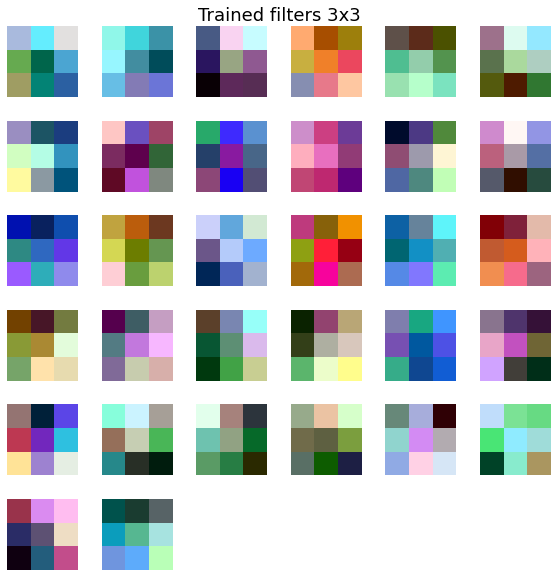

(5, 5, 3, 32)
(32, 5, 5, 3)


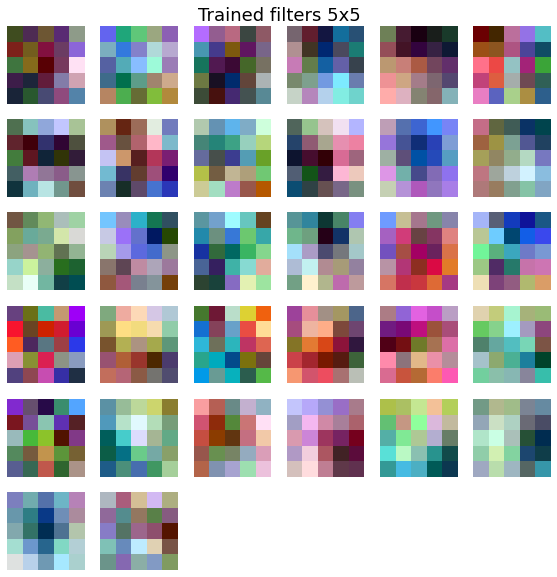

(7, 7, 3, 32)
(32, 7, 7, 3)


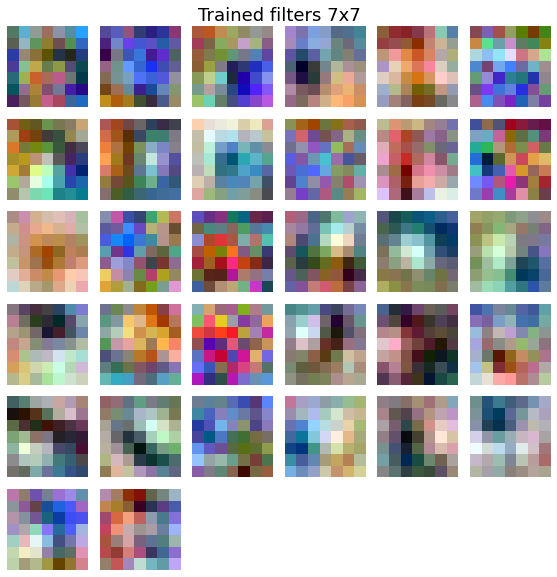

(9, 9, 3, 32)
(32, 9, 9, 3)


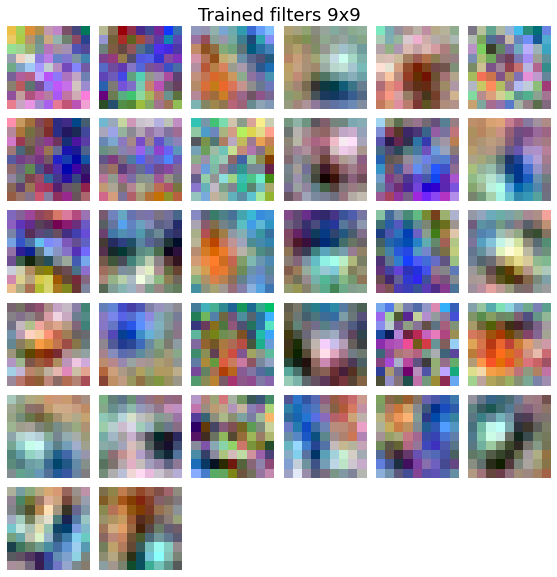

(11, 11, 3, 32)
(32, 11, 11, 3)


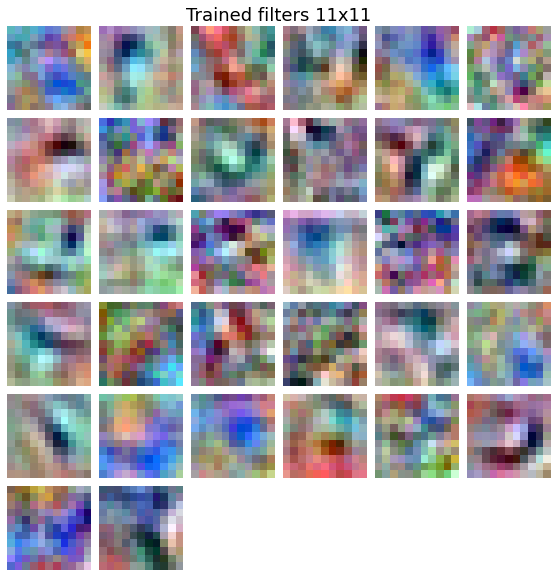

(13, 13, 3, 32)
(32, 13, 13, 3)


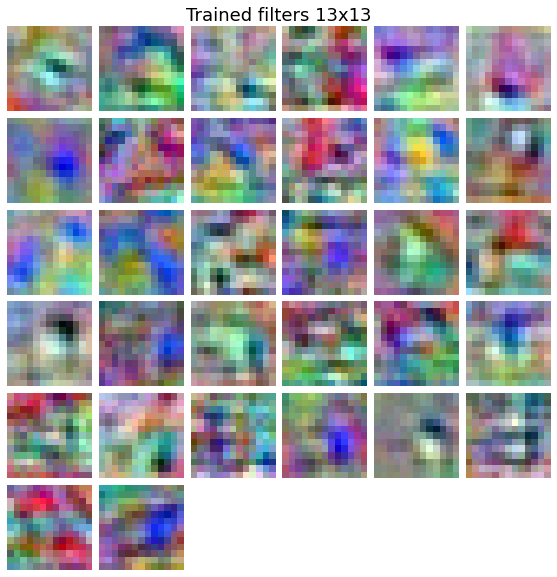

(15, 15, 3, 32)
(32, 15, 15, 3)


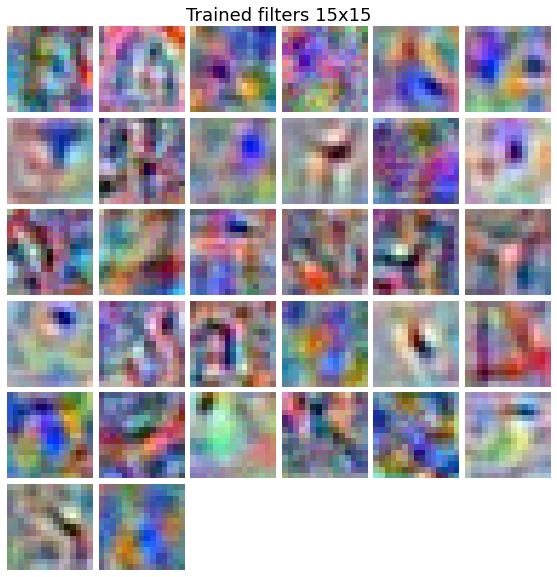

(19, 19, 3, 32)
(32, 19, 19, 3)


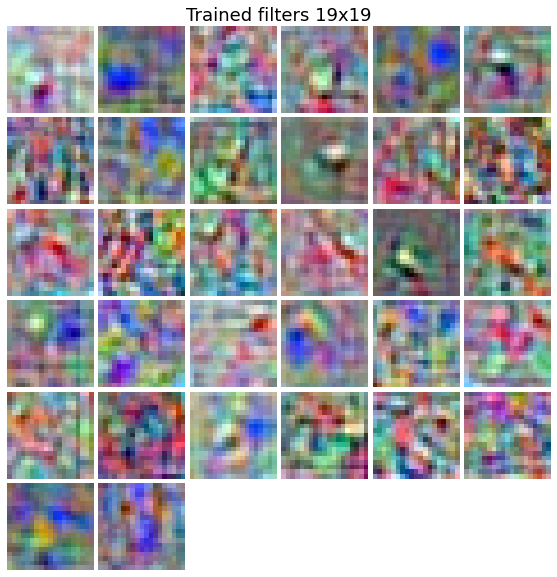

In [ ]:
for i in range(len(model)-4):
    w = model[i].get_weights()
    print(w[0].shape)
    # print(model[i].get_config())
    # l = model[i].layers
    # print(l[0].get_weights()[0].shape)

    # Visualizing filters
    temp = w[0].transpose(3, 0, 1, 2)
    print(temp.shape)  # (81, 32, 32, 3)

    # Plotting
    fig = plt.figure()
    grid = convert_to_grid(temp)
    plt.imshow(grid.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 10)
    name = 'Trained filters ' + str(filter_size[i]) + 'x' + str(filter_size[i])
    plt.title(name, fontsize=18)
    
    # Showing the plot
    plt.show()

    # Saving the plot
    name = 'filters-' + str(filter_size[i]) + 'x' + str(filter_size[i]) + '.png'
    fig.savefig(name)
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)
[2]


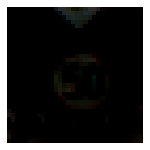

(43,)
ClassId: 2
Label: Speed limit (50km/h)


In [ ]:
%matplotlib inline

# Preparing image for predicting from test dataset
x_input = data['x_test'][311:312]
print(x_input.shape)
y_input = data['y_test'][311:312]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
#scores = model[0].predict(x_input)
scores = model[1].predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)
# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('/content/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])

In [ ]:
for i in range(len(model)-4):
    name = 'model-' + str(filter_size[i]) + 'x' + str(filter_size[i]) + '.h5'
    model[i].save(name)